## Before the lecture

- Google Drive
- Assignments: do NOT use untaught methods in assignment/competition/project.
- Project is not a thesis

# House Keeping

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import itertools
import statsmodels.formula.api as smf
from patsy.builtins import Q
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import sy_functions as sy

The above function file is [here](https://www.dropbox.com/s/zzz9ddc5dfknew9/sy_functions.py?dl=1).

# Reading

Textbook Page 41-61, 69-76

# Linear Model

$$E(y\mid x)=f(x'\beta)$$

where $x'\beta=\beta_0+x_1\beta_1+...+x_p\beta_p$.
This is a generalised linear regression form.

You have already seen the package `statsmodels.api`
for the linear regression model.

A starting model is always linear by heart and look as

$$E(y\mid x)=x'\beta$$

- What is the meaning of [**regression**](https://en.wikipedia.org/wiki/Regression_analysis#History)?

## Orange Juice

In [ ]:
df_oj = pd.read_csv("https://www.dropbox.com/s/8oll01xv92mkij8/oj.csv?dl=1")
df_oj['log price'] = np.log(df_oj['price'])
df_oj['log sales'] = np.log(df_oj['sales'])
df_oj = sm.add_constant(df_oj)
df_oj

,const,sales,price,brand,feat,log price,log sales
0,1.0,8256.0,3.87,tropicana,0,1.353255,9.018695
1,1.0,6144.0,3.87,tropicana,0,1.353255,8.723231
2,1.0,3840.0,3.87,tropicana,0,1.353255,8.253228
3,1.0,8000.0,3.87,tropicana,0,1.353255,8.987197
4,1.0,8896.0,3.87,tropicana,0,1.353255,9.093357
...,...,...,...,...,...,...,...
28942,1.0,2944.0,2.00,dominicks,0,0.693147,7.987524
28943,1.0,4928.0,1.94,dominicks,0,0.662688,8.502689
28944,1.0,13440.0,1.59,dominicks,0,0.463734,9.505991
28945,1.0,55680.0,1.49,dominicks,0,0.398776,10.927376


In [ ]:
df_oj.info() # type: ignore

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28947 entries, 0 to 28946
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   const      28947 non-null  float64
 1   sales      28947 non-null  float64
 2   price      28947 non-null  float64
 3   brand      28947 non-null  object 
 4   feat       28947 non-null  int64  
 5   log price  28947 non-null  float64
 6   log sales  28947 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.5+ MB


In [ ]:
df_oj['brand'].describe() # pyright: ignore[reportAttributeAccessIssue]

count         28947
unique            3
top       tropicana
freq           9649
Name: brand, dtype: object

In [ ]:
df_oj['brand'].value_counts() # type: ignore

brand
tropicana      9649
minute.maid    9649
dominicks      9649
Name: count, dtype: int64

In [ ]:
fig = px.box(df_oj, x='price', color='brand')
# Update the layout
fig.update_layout(
    title='Box plot',
    xaxis=dict(title='Price'),
)
fig.show()

In [ ]:
fig = px.box(df_oj, x='log price', color='brand')
# Update the layout
fig.update_layout(
    title='Box plot',
    xaxis=dict(title='Log Price'),
)
fig.show()

In [ ]:
# Violin plot
figsize = (8, 1.2 * len(df_oj['brand'].unique())) # type: ignore

fig = px.violin(df_oj, x='log price', y='brand', color='brand',
                template='simple_white')

fig.update_layout(width=figsize[0]*100, height=figsize[1]*100)

fig.update_layout(
    xaxis=dict(showline=False, zeroline=False),
    yaxis=dict(showline=False, zeroline=False)
)

fig.show()

In [ ]:
fig = px.scatter(df_oj, x='log price', y = 'log sales', color='brand')
# Update the layout
fig.update_layout(
    title='Scatter plot',
    xaxis=dict(title='Log Price'),
    yaxis=dict(title='Log Sales'),
)
fig.show()

$\color{red}{Question:}$ Find the sample means of the log prices for each brand.

## regression

In [ ]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
dummy_variables = pd.DataFrame(encoder.fit_transform(df_oj[['brand']]))
dummy_variables.columns = encoder.get_feature_names_out()
df = pd.concat([df_oj, dummy_variables], axis=1) # type: ignore
df

,const,sales,price,brand,feat,log price,log sales,brand_minute.maid,brand_tropicana
0,1.0,8256.0,3.87,tropicana,0,1.353255,9.018695,0.0,1.0
1,1.0,6144.0,3.87,tropicana,0,1.353255,8.723231,0.0,1.0
2,1.0,3840.0,3.87,tropicana,0,1.353255,8.253228,0.0,1.0
3,1.0,8000.0,3.87,tropicana,0,1.353255,8.987197,0.0,1.0
4,1.0,8896.0,3.87,tropicana,0,1.353255,9.093357,0.0,1.0
...,...,...,...,...,...,...,...,...,...
28942,1.0,2944.0,2.00,dominicks,0,0.693147,7.987524,0.0,0.0
28943,1.0,4928.0,1.94,dominicks,0,0.662688,8.502689,0.0,0.0
28944,1.0,13440.0,1.59,dominicks,0,0.463734,9.505991,0.0,0.0
28945,1.0,55680.0,1.49,dominicks,0,0.398776,10.927376,0.0,0.0


In [ ]:
X_list = ['log price'] +dummy_variables.columns.values.tolist()
X_list

['log price', 'brand_minute.maid', 'brand_tropicana']

In [ ]:
X = df[X_list]
y = df['log sales']

In [ ]:
model = LinearRegression()
model.fit(X, y)

# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Print the results
print('Coefficients:', coefficients)
print('Intercept:', intercept)

Coefficients: [-3.13869143  0.87017465  1.52994276]
Intercept: 10.82882157956506


In [ ]:
X_list = ['const', 'log price'] +dummy_variables.columns.values.tolist()
print(X_list)
X = df[X_list]
y = df['log sales']

stats_model = sm.OLS(y, X)
results = stats_model.fit()

['const', 'log price', 'brand_minute.maid', 'brand_tropicana']


In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log sales   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     6275.
Date:                Fri, 01 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:20:44   Log-Likelihood:                -34377.
No. Observations:               28947   AIC:                         6.876e+04
Df Residuals:                   28943   BIC:                         6.880e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.8288      0.01

$\color{red}{𝑄𝑢𝑒𝑠𝑡𝑖𝑜𝑛:}$
- What are the meanings of these coefficients?
- Why one brand is missing?
- What is a default group when you use dummy variables?

We can save the coefficients separately. And what is more, we can see how the different constants for the three brands shift the regression line around. But our model assumed (allowed) the same price elasticity for the three brands.

- Is this a reasonable assumption? Why or why not?
- Is there a reasonable explanation for the difference in the intercepts?

In [ ]:
fig = px.scatter(df_oj, x='log price', y = 'log sales', color='brand')
# Update the layout
fig.update_layout(
    title='Scatter plot',
    xaxis=dict(title='Log Price'),
    yaxis=dict(title='Log Sales'),
)
intercept = results.params['const']
slope = results.params['log price']
x_line = np.linspace(min(df_oj['log price']), max(df_oj['log price']), 100)
y_line = intercept + slope * x_line

line_trace = go.Scattergl(
    x=x_line,
    y=y_line,
    mode='lines',
    line=dict(color='#00cc96', width=2),  # You can customize the line color and width here
    name='Dominicks',
)
# Add the line trace to the figure
fig.add_trace(line_trace)

intercept = results.params['const'] + results.params['brand_minute.maid']
slope = results.params['log price']
x_line = np.linspace(min(df_oj['log price']), max(df_oj['log price']), 100)
y_line = intercept + slope * x_line

line_trace = go.Scattergl(
    x=x_line,
    y=y_line,
    mode='lines',
    line=dict(color='#EF553B', width=2),  # You can customize the line color and width here
    name='Minute Maid',
)
fig.add_trace(line_trace)

intercept = results.params['const'] + results.params['brand_tropicana']
slope = results.params['log price']
x_line = np.linspace(min(df_oj['log price']), max(df_oj['log price']), 100)
y_line = intercept + slope * x_line

line_trace = go.Scattergl(
    x=x_line,
    y=y_line,
    mode='lines',
    line=dict(color='#636efa', width=2),  # You can customize the line color and width here
    name='Tropicana',
)
fig.add_trace(line_trace)

fig.show()

## Interactions
Add **interactions** to capture heterogeneous effects (price elasticity).

For example,
$$y = \beta_0 + x\beta_2 + d\beta_3 + \varepsilon,$$
where $x$ and $d$ are scalars with $d$ being the dummy variable. After adding interaction,
$$y = \beta_0 + x\beta_2 + d\beta_3 +xd\beta_4+ \varepsilon.$$
This can be rearranged as
$$y = \beta_0 + x(\beta_2+d\beta_4) + d\beta_3 + \varepsilon,$$
with marginal effect of $x$ on $y$ as $\beta_2+d\beta_4$. This marginal effect depends on the dummy (or factor) and hence heterogeneous among different groups.


- what is the default group?
- How should we interpret the results?

In [ ]:
print(df_oj.head()) # type: ignore
df = pd.get_dummies(df_oj, columns=['brand'])
print(df.columns)

for col in df.columns:
    if 'brand_' in col:
        df[col] = df[col].astype(int)

print(df.head())

   const   sales  price      brand  feat  log price  log sales
0    1.0  8256.0   3.87  tropicana     0   1.353255   9.018695
1    1.0  6144.0   3.87  tropicana     0   1.353255   8.723231
2    1.0  3840.0   3.87  tropicana     0   1.353255   8.253228
3    1.0  8000.0   3.87  tropicana     0   1.353255   8.987197
4    1.0  8896.0   3.87  tropicana     0   1.353255   9.093357
Index(['const', 'sales', 'price', 'feat', 'log price', 'log sales',
       'brand_dominicks', 'brand_minute.maid', 'brand_tropicana'],
      dtype='object')
   const   sales  price  feat  log price  log sales  brand_dominicks  \
0    1.0  8256.0   3.87     0   1.353255   9.018695                0   
1    1.0  6144.0   3.87     0   1.353255   8.723231                0   
2    1.0  3840.0   3.87     0   1.353255   8.253228                0   
3    1.0  8000.0   3.87     0   1.353255   8.987197                0   
4    1.0  8896.0   3.87     0   1.353255   9.093357                0   

   brand_minute.maid  brand_trop

In [ ]:
pattern = r'^brand.*'
df.filter(regex=pattern) # this can be helpful in your project

,brand_dominicks,brand_minute.maid,brand_tropicana
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
28942,1,0,0
28943,1,0,0
28944,1,0,0
28945,1,0,0


In [ ]:
x_list = ['const', 'log price']
for brand in ['brand_minute.maid', 'brand_tropicana']:
  interaction = f'log price: {brand}'
  df[interaction] = df['log price'] * df[brand]
  x_list.append(brand)
  x_list.append(interaction)
df

,const,sales,price,feat,log price,log sales,brand_dominicks,brand_minute.maid,brand_tropicana,log price: brand_minute.maid,log price: brand_tropicana
0,1.0,8256.0,3.87,0,1.353255,9.018695,0,0,1,0.0,1.353255
1,1.0,6144.0,3.87,0,1.353255,8.723231,0,0,1,0.0,1.353255
2,1.0,3840.0,3.87,0,1.353255,8.253228,0,0,1,0.0,1.353255
3,1.0,8000.0,3.87,0,1.353255,8.987197,0,0,1,0.0,1.353255
4,1.0,8896.0,3.87,0,1.353255,9.093357,0,0,1,0.0,1.353255
...,...,...,...,...,...,...,...,...,...,...,...
28942,1.0,2944.0,2.00,0,0.693147,7.987524,1,0,0,0.0,0.000000
28943,1.0,4928.0,1.94,0,0.662688,8.502689,1,0,0,0.0,0.000000
28944,1.0,13440.0,1.59,0,0.463734,9.505991,1,0,0,0.0,0.000000
28945,1.0,55680.0,1.49,0,0.398776,10.927376,1,0,0,0.0,0.000000


In [ ]:
X = df[x_list]
y = df['log sales']

stats_model = sm.OLS(y, X)
results = stats_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log sales   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     3823.
Date:                Fri, 01 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:29:21   Log-Likelihood:                -34289.
No. Observations:               28947   AIC:                         6.859e+04
Df Residuals:                   28941   BIC:                         6.864e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [ ]:
fig = px.scatter(df_oj, x='log price', y = 'log sales', color='brand')
# Update the layout
fig.update_layout(
    title='Scatter plot',
    xaxis=dict(title='Log Price'),
    yaxis=dict(title='Log Sales'),
)
intercept = results.params['const']
slope = results.params['log price']
x_line = np.linspace(min(df_oj['log price']), max(df_oj['log price']), 100)
y_line = intercept + slope * x_line

line_trace = go.Scattergl(
    x=x_line,
    y=y_line,
    mode='lines',
    line=dict(color='#00cc96', width=2),  # You can customize the line color and width here
    name='Dominicks',
)
# Add the line trace to the figure
fig.add_trace(line_trace)

intercept = results.params['const'] + results.params['brand_minute.maid']
slope = results.params['log price'] + results.params['log price: brand_minute.maid']
x_line = np.linspace(min(df_oj['log price']), max(df_oj['log price']), 100)
y_line = intercept + slope * x_line

line_trace = go.Scattergl(
    x=x_line,
    y=y_line,
    mode='lines',
    line=dict(color='#EF553B', width=2),  # You can customize the line color and width here
    name='Minute Maid',
)
fig.add_trace(line_trace)

intercept = results.params['const'] + results.params['brand_tropicana']
slope = results.params['log price'] + results.params['log price: brand_tropicana']
x_line = np.linspace(min(df_oj['log price']), max(df_oj['log price']), 100)
y_line = intercept + slope * x_line

line_trace = go.Scattergl(
    x=x_line,
    y=y_line,
    mode='lines',
    line=dict(color='#636efa', width=2),  # You can customize the line color and width here
    name='Tropicana',
)
fig.add_trace(line_trace)

fig.show()

## triple interactions

In [ ]:
# use a formula
model = smf.ols(formula = "Q('log sales') ~ Q('log price')*brand", data=df_oj)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Q('log sales')   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     3823.
Date:                Fri, 01 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:29:48   Log-Likelihood:                -34289.
No. Observations:               28947   AIC:                         6.859e+04
Df Residuals:                   28941   BIC:                         6.864e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [ ]:
model = smf.ols(formula = "Q('log sales') ~ Q('log price')*brand*feat", data=df_oj)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Q('log sales')   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     3031.
Date:                Fri, 01 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:30:19   Log-Likelihood:                -30534.
No. Observations:               28947   AIC:                         6.109e+04
Df Residuals:                   28935   BIC:                         6.119e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

$\color{red}{Question:}$ Predict `log sale` for Tropicana when its price is set at its sample mean and on promotion.

# Logistic Regression

## SPAM

Not this <img src="https://www.dropbox.com/s/c1ahwt557itwfmv/spam.png?dl=1" width=200>, but this
<img src="https://www.dropbox.com/s/46kuyh6pnovqla2/Spammed-mail-folder.png?dl=1" width=200>

It is Bayesian

$$P(Spam | Features) = \frac{P(Features | Spam) \times P(Spam)}{P(Features)}$$

In [ ]:
df_spam = pd.read_csv("https://www.dropbox.com/s/nh3fd6c58ut4a5l/spam.csv?dl=1")
df_spam

,word_make,word_address,word_all,word_3d,word_our,word_over,word_remove,word_internet,word_order,word_mail,...,char_semicolon,char_leftbrac,char_leftsquarebrac,char_exclaim,char_dollar,char_pound,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,3.756,61,278,1
1,1,1,1,0,1,1,1,1,0,1,...,0,1,0,1,1,1,5.114,101,1028,1
2,1,0,1,0,1,1,1,1,1,1,...,1,1,0,1,1,1,9.821,485,2259,1
3,0,0,0,0,1,0,1,1,1,1,...,0,1,0,1,0,0,3.537,40,191,1
4,0,0,0,0,1,0,1,1,1,1,...,0,1,0,1,0,0,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,1,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1.142,3,88,0
4597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1.555,4,14,0
4598,1,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1.404,6,118,0
4599,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1.147,5,78,0


## model:

If the dependent variabl $y$ has only two outcomes, a good method could be Logistic regression by modelling the conditional probability explicitly.
$$p(y=1\mid x)=\frac{e^{x'\beta}}{1+e^{x'\beta}}.$$
The linear part $x'\beta$ gives an index value. A large positive value pushes the probability toward $1$ while a large negative value pulls the probability towards $0$.

Another representation (same model) is
$$\log\left[\frac{p}{1-p}\right]=x'\beta,$$
where $p=p(y=1\mid x)$. Or,
$$\log\left[\frac{p(y=1\mid x)}{p(y=0\mid x)}\right]=x'\beta.$$
The LHS is the **log odds ratio**. The interpretation for any $\beta_k$ comes as the marginal effect on the log odds ratio.

- Logistic regression has a utility interpretation.

In [ ]:
X = df_spam.drop(columns='spam')
X['intercept'] = 1
y = df_spam['spam']
logit_model = sm.Logit(y, X)
results = logit_model.fit()

# Print the summary of the logistic regression model
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.168296
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 4601
Model:                          Logit   Df Residuals:                     4543
Method:                           MLE   Df Model:                           57
Date:                Fri, 01 Aug 2025   Pseudo R-squ.:                  0.7490
Time:                        21:31:46   Log-Likelihood:                -774.33
converged:                       True   LL-Null:                       -3085.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
word_make                     -0.5530      0.236     -2.346      0.019     

$\color{red}{Question:}$ how many coefficients are significant at 5\% significance level?

In [ ]:
np.exp(results.params['word_george'])

np.float64(0.003089205351958126)

In [ ]:
contingency_table = pd.crosstab(df_spam['word_george'], df_spam['spam'], values=df_spam['spam'], aggfunc='count')
print(contingency_table)

spam            0     1
word_george            
0            2016  1805
1             772     8


In [ ]:
np.exp(results.params['word_free'])

np.float64(4.677229408409597)

In [ ]:
contingency_table = pd.crosstab(df_spam['word_free'], df_spam['spam'], values=df_spam['spam'], aggfunc='count')
print(contingency_table)

spam          0    1
word_free           
0          2536  824
1           252  989


This is how you plot fitted (estimated) probabilities from a logistic model against the original categories.
- This is in-sample fitting.
- Hard to read?
- Is there any information to tell?

In [ ]:
fitted_values = results.predict(X)
plot_data = pd.DataFrame({'Fitted Values': fitted_values, 'True Values': df_spam['spam']})

# Create the box plot using Plotly
fig = px.box(plot_data, x='True Values', y='Fitted Values')

# Update the plot layout
fig.update_layout(
    title="In-sample Prediction",
    xaxis_title="True Values",
    yaxis_title="Fitted Values",
)

# Show the plot
fig.show()

## Out-of-sample predictions (OOS)

**OOS** is important for the machine learning literature. It is arguably the only fair criterion for model comparison.
The techniques/models from this subject shall use OOS intensively.

In [ ]:
# split the data
df_test = df_spam.sample(n=1000)
df_train = df_spam.drop(df_test.index)

In [ ]:
# training
X = df_train.drop(columns='spam')
X['intercept'] = 1
y = df_train['spam']
logit_model = sm.Logit(y, X)
results = logit_model.fit()

# Print the summary of the logistic regression model
print(results.summary())

         Current function value: 0.172798
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 3601
Model:                          Logit   Df Residuals:                     3543
Method:                           MLE   Df Model:                           57
Date:                Fri, 01 Aug 2025   Pseudo R-squ.:                  0.7428
Time:                        21:34:36   Log-Likelihood:                -622.24
converged:                      False   LL-Null:                       -2419.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
word_make                     -0.7780      0.274     -2.839      0.005      -1.315      -0.241
word_address     

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
X = df_test.drop(columns='spam')
X['intercept'] = 1
y = df_test['spam']
oos_prediction = results.predict(X)

In [ ]:
oos_prediction

1359    9.999992e-01
2338    1.213246e-02
2215    6.103373e-02
2976    3.706837e-02
1971    1.378310e-01
            ...     
2923    4.134303e-13
1313    9.999886e-01
2394    8.633009e-03
4392    9.997327e-01
1609    9.997568e-01
Length: 1000, dtype: float64

In [ ]:
plot_data = pd.DataFrame({'Fitted Values': oos_prediction, 'True Values': df_test['spam']})

# Create the box plot using Plotly
fig = px.box(plot_data, x='True Values', y='Fitted Values')

# Update the plot layout
fig.update_layout(
    title="Out-of-sample Prediction",
    xaxis_title="True Values",
    yaxis_title="Fitted Values",
)

# Show the plot
fig.show()

## Deviance

We can go back to the [`deviance`](https://www.dropbox.com/s/xrapwrr64me2lnq/deviance.R?dl=0) for calculating deviance between actual observations and a prediction. It does not matter whether these predictions were in-sample or out-of. Just remember to specify the family correctly.

- Remembering the formula is NOT the best idea. Do you understand the meaning of deviance? Is it better to be large or small?

- The following deviance function is translated by chatGPT from Matt Taddy's `R` source code [here](https://www.dropbox.com/s/xrapwrr64me2lnq/deviance.R?dl=1).

- See [likelihood ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test).

In [ ]:
def deviance(y, pred, family='binomial'):
    """
    Calculate the deviance for different families.

    Parameters:
        y : array-like
            The observed response variable.
        pred : array-like
            The predicted probabilities.
        family : str, optional (default: 'binomial')
            The family of the response variable. Valid options are 'gaussian' for continuous and 'binomial' for binary.

    Returns:
        float
            The deviance value.
    """
    family = family.lower()
    if family == 'gaussian':
        return np.sum((y - pred) ** 2)
    else:
        y = np.asarray(y)
        pred = np.asarray(pred)
        return -2 * np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred))

In [ ]:
deviance(df_test['spam'], oos_prediction, 'binomial')

np.float64(355.77080331555396)

In [ ]:
# null deviance is the deviance when there is NO covariate x
ybar = df_train.spam.mean()
deviance(y=df_test.spam, pred=ybar, family="binomial")

np.float64(1331.0630357999735)

$R^2$

In [ ]:
def R2(y, pred, family='binomial'):
    """
    Calculate the R-squared value for different families.

    Parameters:
        y : array-like
            The observed response variable.
        pred : array-like
            The predicted probabilities.
        family : str, optional (default: 'binomial')
            The family of the response variable. Valid options are 'gaussian' for continuous and 'binomial' for binary.

    Returns:
        float
            The R-squared value.
    """
    family = family.lower()
    if family == 'binomial':
        y = np.asarray(y)
    dev = deviance(y, pred, family=family)
    dev0 = deviance(y, np.mean(y), family=family)
    return 1 - dev / dev0

In [ ]:
R2(df_test['spam'], oos_prediction, 'binomial')

np.float64(0.7325171287816743)

# Uncertainty

In [ ]:
df_air = pd.read_csv("https://www.dropbox.com/s/jdcjsm26nkj8wbe/airquality.csv?dl=1")
df_air = df_air.iloc[:, 1:]
df_air.rename(columns={'Solar.R': 'Solar_R'}, inplace=True)
df_air

,Ozone,Solar_R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


## standard error

Some concepts:

- what is an estimator?
- what is an estimate?
- what is the standard deviation?
- what is the standard error?

In [ ]:
x_variables = ' + '.join(df_air.columns.difference(['Ozone']))
formula = f'Ozone ~ {x_variables}'

model = smf.ols(formula = formula, data=df_air)
results = model.fit()
print(results.summary())

results_ols = results

                            OLS Regression Results                            
Dep. Variable:                  Ozone   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     34.99
Date:                Fri, 01 Aug 2025   Prob (F-statistic):           6.50e-21
Time:                        21:37:02   Log-Likelihood:                -491.61
No. Observations:                 111   AIC:                             995.2
Df Residuals:                     105   BIC:                             1011.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -64.1163     23.482     -2.730      0.0

## Heteroskedasticity

Heteroskedasticity is an often met problem.
$$y=x'\beta + ɛ$$

- Homoskedasticy, $var(ɛ\mid x)=\sigma^2$, give credits equally to all observations.
- Heteroskedasticiy, $var(ɛ\mid x)=g(x)$, assumes different observation have different credibility.

In [ ]:
results_ols.HC3_se

Intercept    20.805627
Day           0.255942
Month         1.349839
Solar_R       0.020780
Temp          0.223611
Wind          0.912888
dtype: float64

## bootstrap standard errors

Bootstrap methods mimic the DGP and sampling distribution by using the existing data.

In [ ]:
B = 1000
n = 153 # or use n = df_air.shape[0]
wind_coeffs = np.zeros(B)

x_variables = ' + '.join(df_air.columns.difference(['Ozone']))
formula = f'Ozone ~ {x_variables}'

for iter in range(B):
  # sample
  df_B = df_air.sample(n=n, replace=True)
  model = smf.ols(formula = formula, data=df_B)
  results = model.fit()
  wind_coeffs[iter] = results.params['Wind']

In [ ]:
df = pd.DataFrame({'Wind coefficient': wind_coeffs})

fig = px.histogram(df, x='Wind coefficient', histnorm='probability density')
# Update the layout
fig.update_layout(
    title='Histogram',
    xaxis=dict(title='Bootstrapped Wind Coefficients'),
    yaxis=dict(title='Frequency'),
)

betahat = results_ols.params['Wind']
se = results_ols.bse['Wind']
x = np.linspace(np.min(wind_coeffs), np.max(wind_coeffs), 100)
y = norm.pdf(x, betahat, se)
fig.add_scatter(x=x, y=y, mode='lines', name='Homoskedasticity')

se = results_ols.HC3_se['Wind']
x = np.linspace(np.min(wind_coeffs), np.max(wind_coeffs), 100)
y = norm.pdf(x, betahat, se)
fig.add_scatter(x=x, y=y, mode='lines', name='HC3')

fig.show()

$\color{red}{Question}:$ Bootstrap the coefficient of the temperature variable. Draw a similar figure as the `Wind` example.

# Cross Validation

## Semiconductors

In [ ]:
df_sc = pd.read_csv("https://www.dropbox.com/s/hl26fuodi5zalo5/semiconductor.csv?dl=1")
df_sc

,FAIL,SIG1,SIG2,SIG3,SIG4,SIG5,SIG6,SIG7,SIG8,SIG9,...,SIG191,SIG192,SIG193,SIG194,SIG195,SIG196,SIG197,SIG198,SIG199,SIG200
0,0,2.223779,-0.349018,-1.985797,-2.600993,0.451092,0.856625,0.019999,5.552095,-1.217598,...,-0.493650,-0.081946,-0.026963,0.069390,0.000884,-0.090158,0.567668,0.136708,0.258290,-0.110619
1,1,-0.130378,-0.381318,-1.285172,-0.766302,-3.098302,1.257852,0.792258,3.052683,-0.596629,...,-0.242341,-0.040653,-0.248808,-0.206819,-0.113580,0.087156,-0.075984,0.359806,0.352307,-0.065168
2,0,-0.871138,-0.825300,-1.615008,-0.448803,-2.570782,-1.345798,3.561107,2.748009,-0.898133,...,-0.210873,-0.224043,-0.668168,-0.067575,-0.557790,0.050106,0.352167,-0.136979,0.270314,0.231886
3,0,-0.877341,-1.905598,-2.306114,-1.210761,-4.037471,-2.223608,2.404128,0.769476,5.605738,...,-0.244826,0.100125,-0.016613,0.139226,0.153687,-0.222902,-0.324682,0.330688,-0.053124,-0.046525
4,0,-2.113456,-2.313845,-2.917153,-3.333467,-4.439346,3.029632,-0.177130,0.268809,2.673137,...,0.523039,-0.104421,0.110383,0.099062,0.347613,-0.213793,0.090675,0.081936,-0.129969,-0.435595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,0,-1.216544,2.933523,3.125961,6.299250,-4.701302,-0.736551,3.274427,-2.604696,-1.287880,...,0.137749,-0.057304,-0.005772,0.044957,0.014158,-0.256404,0.094116,0.003980,-0.392673,-0.156949
1473,0,1.519838,0.929747,-1.755750,-0.627124,0.134864,-0.277557,0.433767,2.599539,0.523947,...,-0.070191,-0.446749,-0.038911,0.276027,0.146811,0.092740,-0.012873,0.173764,0.011626,-0.140552
1474,0,1.186808,3.124830,1.554038,7.640257,-2.306926,-0.103164,-0.717412,-0.002707,-1.555463,...,0.104973,0.738707,0.183454,-0.538684,0.066061,-0.045803,-0.223485,-0.244998,0.270780,-0.206376
1475,0,0.418682,-0.560838,-2.849019,-2.070624,-2.299557,4.606691,-2.472302,1.304957,-0.820954,...,0.235377,0.323977,-0.046804,0.033842,-0.230825,0.045902,0.093716,0.194718,-0.463204,0.210923


Full model

- dependent variable is chip failure taking values 0 or 1.
- 1 means fail, and 0 means OK.
- independent variables are 200 diagnostic signals.
- Logistic regression of y on 200 variables.

In [ ]:
x_variables = ' + '.join(df_sc.columns.difference(['FAIL']))
formula = f'FAIL ~ {x_variables}'

model = sm.Logit.from_formula(formula, data = df_sc)
results = model.fit()
print(results.summary())

formula_full = formula # for use later.

Optimization terminated successfully.
         Current function value: 0.108440
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                   FAIL   No. Observations:                 1477
Model:                          Logit   Df Residuals:                     1276
Method:                           MLE   Df Model:                          200
Date:                Fri, 01 Aug 2025   Pseudo R-squ.:                  0.5621
Time:                        21:39:14   Log-Likelihood:                -160.17
converged:                       True   LL-Null:                       -365.80
Covariance Type:            nonrobust   LLR p-value:                 1.008e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.6086      0.996     -8.644      0.000     -10.561      -6.657
SIG1           0.0181      0

In [ ]:
prediction_in_sample = results.predict(df_sc)
sy.R2(df_sc['FAIL'], prediction_in_sample, family='binomial')

np.float64(0.5621431924743908)

In [ ]:
pvals = results.pvalues
fig = px.histogram(x=pvals)
# Update the layout
fig.update_layout(
    title='p values',
    xaxis=dict(title='p values'),
    yaxis=dict(title='count'),
)

## Benjamini-Hochberg [optional]

Make a correction at 10% FDR. Think Type I error *globally*.

In [ ]:
def fdr_cut(pvals, q=0.1):
    # q=0.1 is the default value. if no q input, it is set as 0.1
    pvals = np.sort(pvals[~np.isnan(pvals)])
    N = len(pvals)
    k = np.argsort(pvals, kind='mergesort') + 1  # The method to deal with ties in ranking is "min"

    alpha = np.max(pvals[pvals <= (q * k / N)])

    plt.figure(figsize=(10, 6))
    plt.plot(pvals, 'o', markersize=4, markerfacecolor='none', markeredgecolor='gray')
    plt.plot(np.arange(1, N + 1), q * np.arange(1, N + 1) / N, color='blue', linestyle='--')
    plt.xlabel('order')
    plt.ylabel('p-value')
    plt.title(f'FDR of {q}')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    return alpha

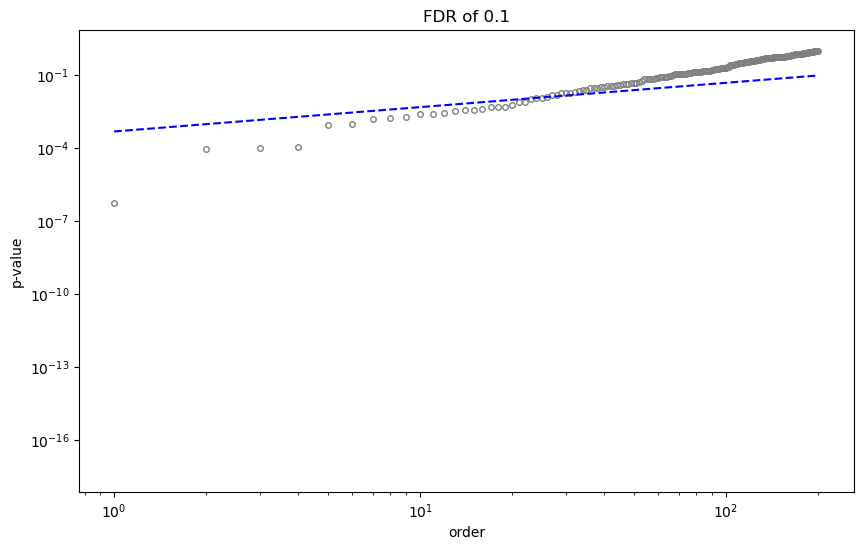

np.float64(0.013413836144454567)

In [ ]:
fdr_cut(pvals)

Using the cutoff to estimate a more parsimonious model.

In [ ]:
x_list = results.pvalues.index[results.pvalues < 0.0134138]
x_list = x_list.drop('Intercept')

In [ ]:
x_variables = ' + '.join(x_list)
formula = f'FAIL ~ {x_variables}'

model = sm.Logit.from_formula(formula, data = df_sc)
results = model.fit()
print(results.summary())

formula_subset = formula # use for K-fold OOS later

Optimization terminated successfully.
         Current function value: 0.202789
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   FAIL   No. Observations:                 1477
Model:                          Logit   Df Residuals:                     1451
Method:                           MLE   Df Model:                           25
Date:                Fri, 01 Aug 2025   Pseudo R-squ.:                  0.1812
Time:                        21:41:18   Log-Likelihood:                -299.52
converged:                       True   LL-Null:                       -365.80
Covariance Type:            nonrobust   LLR p-value:                 1.281e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2897      0.161    -20.379      0.000      -3.606      -2.973
SIG102         0.2596      0.

## K-fold OOS validation

- Makes the estimation trustworthy.
- Avoids over parametrisation (parameter saturation) and favors parsimony.

In [ ]:
x_variables

'SIG102 + SIG111 + SIG136 + SIG142 + SIG154 + SIG166 + SIG17 + SIG178 + SIG186 + SIG189 + SIG19 + SIG2 + SIG20 + SIG200 + SIG22 + SIG24 + SIG46 + SIG47 + SIG49 + SIG50 + SIG52 + SIG59 + SIG61 + SIG69 + SIG83'

In [ ]:
# Number of folds (K)
K = 30

# Initialize KFold object
kf = KFold(n_splits=K, shuffle=True, random_state=12)

deviance_full = np.zeros(K)
deviance_subset = np.zeros(K)
R2_full = np.zeros(K)
R2_subset = np.zeros(K)

# Split the data into K folds
for fold, (train_indices, test_indices) in enumerate(kf.split(df_sc)):
    print("working on ", fold+1, " fold\n")

    train_data = df_sc.iloc[train_indices]
    test_data = df_sc.iloc[test_indices]

    model_full = sm.Logit.from_formula(formula_full, data = train_data)
    results_full = model_full.fit()
    prediction_full = results_full.predict(test_data)
    deviance_full[fold] = sy.deviance(test_data['FAIL'], prediction_full, family='binomial')
    R2_full[fold] = sy.R2(test_data['FAIL'], prediction_full, family='binomial')

    model_subset = sm.Logit.from_formula(formula_subset, data = train_data)
    results_subset = model_subset.fit()
    prediction_subset = results_subset.predict(test_data)
    deviance_subset[fold] = sy.deviance(test_data['FAIL'], prediction_subset, family='binomial')
    R2_subset[fold] = sy.R2(test_data['FAIL'], prediction_subset, family='binomial')

working on  1  fold

Optimization terminated successfully.
         Current function value: 0.104418
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.200403
         Iterations 8
working on  2  fold

Optimization terminated successfully.
         Current function value: 0.103057
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.204486
         Iterations 8
working on  3  fold

Optimization terminated successfully.
         Current function value: 0.095628
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.201154
         Iterations 8
working on  4  fold

Optimization terminated successfully.
         Current function value: 0.105041
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.204484
         Iterations 8
working on  5  fold

Optimization terminated successfully.
         Current function value: 0.10

/Users/yongs1/Library/CloudStorage/GoogleDrive-ysong1@gmail.com/My Drive/AB_teaching/ECOM90025_2025SM2/sy_functions.py:25: RuntimeWarning:

divide by zero encountered in log

/Users/yongs1/Library/CloudStorage/GoogleDrive-ysong1@gmail.com/My Drive/AB_teaching/ECOM90025_2025SM2/sy_functions.py:25: RuntimeWarning:

invalid value encountered in multiply

/Users/yongs1/Library/CloudStorage/GoogleDrive-ysong1@gmail.com/My Drive/AB_teaching/ECOM90025_2025SM2/sy_functions.py:25: RuntimeWarning:

divide by zero encountered in log

/Users/yongs1/Library/CloudStorage/GoogleDrive-ysong1@gmail.com/My Drive/AB_teaching/ECOM90025_2025SM2/sy_functions.py:25: RuntimeWarning:

invalid value encountered in multiply



Optimization terminated successfully.
         Current function value: 0.207677
         Iterations 8
working on  8  fold

Optimization terminated successfully.
         Current function value: 0.103816
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.194507
         Iterations 8
working on  9  fold

Optimization terminated successfully.
         Current function value: 0.097126
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.201165
         Iterations 8
working on  10  fold

Optimization terminated successfully.
         Current function value: 0.105474
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.201983
         Iterations 8
working on  11  fold

Optimization terminated successfully.
         Current function value: 0.096244
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.196798
         Itera

/Users/yongs1/Library/CloudStorage/GoogleDrive-ysong1@gmail.com/My Drive/AB_teaching/ECOM90025_2025SM2/sy_functions.py:25: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully.
         Current function value: 0.107583
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.207608
         Iterations 8
working on  13  fold



/Users/yongs1/Library/CloudStorage/GoogleDrive-ysong1@gmail.com/My Drive/AB_teaching/ECOM90025_2025SM2/sy_functions.py:25: RuntimeWarning:

divide by zero encountered in log

/Users/yongs1/Library/CloudStorage/GoogleDrive-ysong1@gmail.com/My Drive/AB_teaching/ECOM90025_2025SM2/sy_functions.py:25: RuntimeWarning:

invalid value encountered in multiply

/Users/yongs1/Library/CloudStorage/GoogleDrive-ysong1@gmail.com/My Drive/AB_teaching/ECOM90025_2025SM2/sy_functions.py:25: RuntimeWarning:

divide by zero encountered in log

/Users/yongs1/Library/CloudStorage/GoogleDrive-ysong1@gmail.com/My Drive/AB_teaching/ECOM90025_2025SM2/sy_functions.py:25: RuntimeWarning:

invalid value encountered in multiply



Optimization terminated successfully.
         Current function value: 0.109136
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.205307
         Iterations 8
working on  14  fold

Optimization terminated successfully.
         Current function value: 0.106111
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.201695
         Iterations 8
working on  15  fold

Optimization terminated successfully.
         Current function value: 0.109099
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.202837
         Iterations 8
working on  16  fold

Optimization terminated successfully.
         Current function value: 0.090225
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.201734
         Iterations 8
working on  17  fold

Optimization terminated successfully.
         Current function value: 0.103745
         Ite

/Users/yongs1/Library/CloudStorage/GoogleDrive-ysong1@gmail.com/My Drive/AB_teaching/ECOM90025_2025SM2/sy_functions.py:25: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully.
         Current function value: 0.106392
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.202419
         Iterations 8
working on  23  fold

Optimization terminated successfully.
         Current function value: 0.096709
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.198005
         Iterations 8
working on  24  fold

Optimization terminated successfully.
         Current function value: 0.106682
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.205853
         Iterations 8
working on  25  fold



/Users/yongs1/Library/CloudStorage/GoogleDrive-ysong1@gmail.com/My Drive/AB_teaching/ECOM90025_2025SM2/sy_functions.py:25: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully.
         Current function value: 0.104609
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.204071
         Iterations 8
working on  26  fold

Optimization terminated successfully.
         Current function value: 0.099288
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.200691
         Iterations 8
working on  27  fold

Optimization terminated successfully.
         Current function value: 0.102294
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.205169
         Iterations 8
working on  28  fold

Optimization terminated successfully.
         Current function value: 0.108504
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.204736
         Iterations 8
working on  29  fold

Optimization terminated successfully.
         Current function value: 0.103408
         Ite

In [ ]:
trace1 = go.Box(y=deviance_full, name='Full Model')
trace2 = go.Box(y=deviance_subset, name='Pasimonious Model')
# Combine the traces into a data list
data = [trace1, trace2]

# Create the layout for the plot
layout = go.Layout(title='Boxplots of Two OOS Deviances', yaxis=dict(title='Deviance'))

# Create the figure and plot
fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
trace1 = go.Box(y=R2_full, name='Full Model')
trace2 = go.Box(y=R2_subset, name='Pasimonious Model')
# Combine the traces into a data list
data = [trace1, trace2]

# Create the layout for the plot
layout = go.Layout(title='Boxplots of Two OOS R2', yaxis=dict(title='R2'))

# Create the figure and plot
fig = go.Figure(data=data, layout=layout)
fig.show()

They both may not look good. But
- The cut model provides some gains.
- The full model is negative $R^2$. That means we are better off without regression! Just throw away 1 chip for every 15.

- **OOS** matters!!! This is why people put the money in your business!

## Forward stepwise

- The backward stepwise approach is not good as tested by practice. It starts from the full model and removes useless variables.
  - multicollinearity
  - large dimension $p$

- The forward stepwise regression starts from univariate models and adds useful regressors one at a time. This is an example of **greedy** search strategy.

$\color{red}{Question:}$ with help from chatGPT, carry out a greedy search for the best model for the semiconductor application.